![](https://i.postimg.cc/brs9dM8C/Screenshot-2025-06-29-113613.png/)

# Introduction and Imports

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam

2025-11-14 15:02:18.554350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763132538.754276      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763132538.804657      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
##   Project: Action Recognition using CNN + LSTM (UCF50 - 18 classes)
##  Goal: Classify videos based on actions using deep learning (TimeDistributed CNN + LSTM)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense

# Define Classes and Paths

In [3]:
# Define the 18 selected action classes
selected_classes = [
    "Basketball",
    "Diving",
    "HorseRace",
    "JumpRope",
    "VolleyballSpiking",
    "WalkingWithDog",
    "BenchPress",
    "Biking",
    "GolfSwing",
    "HighJump",
    "Kayaking",
    "PullUps",
    "PushUps",
    "RopeClimbing",
    "SkateBoarding",
    "SoccerJuggling",
    "Swing",
    "TrampolineJumping"
]

# UCF50 dataset path
dataset_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50"

# Confirm folder structure
for cls in selected_classes:
    print(f"{cls} → Total videos:", len(os.listdir(os.path.join(dataset_path, cls))))


Basketball → Total videos: 137
Diving → Total videos: 153
HorseRace → Total videos: 127
JumpRope → Total videos: 148
VolleyballSpiking → Total videos: 116
WalkingWithDog → Total videos: 123
BenchPress → Total videos: 160
Biking → Total videos: 145
GolfSwing → Total videos: 142
HighJump → Total videos: 123
Kayaking → Total videos: 157
PullUps → Total videos: 120
PushUps → Total videos: 106
RopeClimbing → Total videos: 130
SkateBoarding → Total videos: 120
SoccerJuggling → Total videos: 156
Swing → Total videos: 137
TrampolineJumping → Total videos: 119


# EDA – Show Sample Frames from Each Class

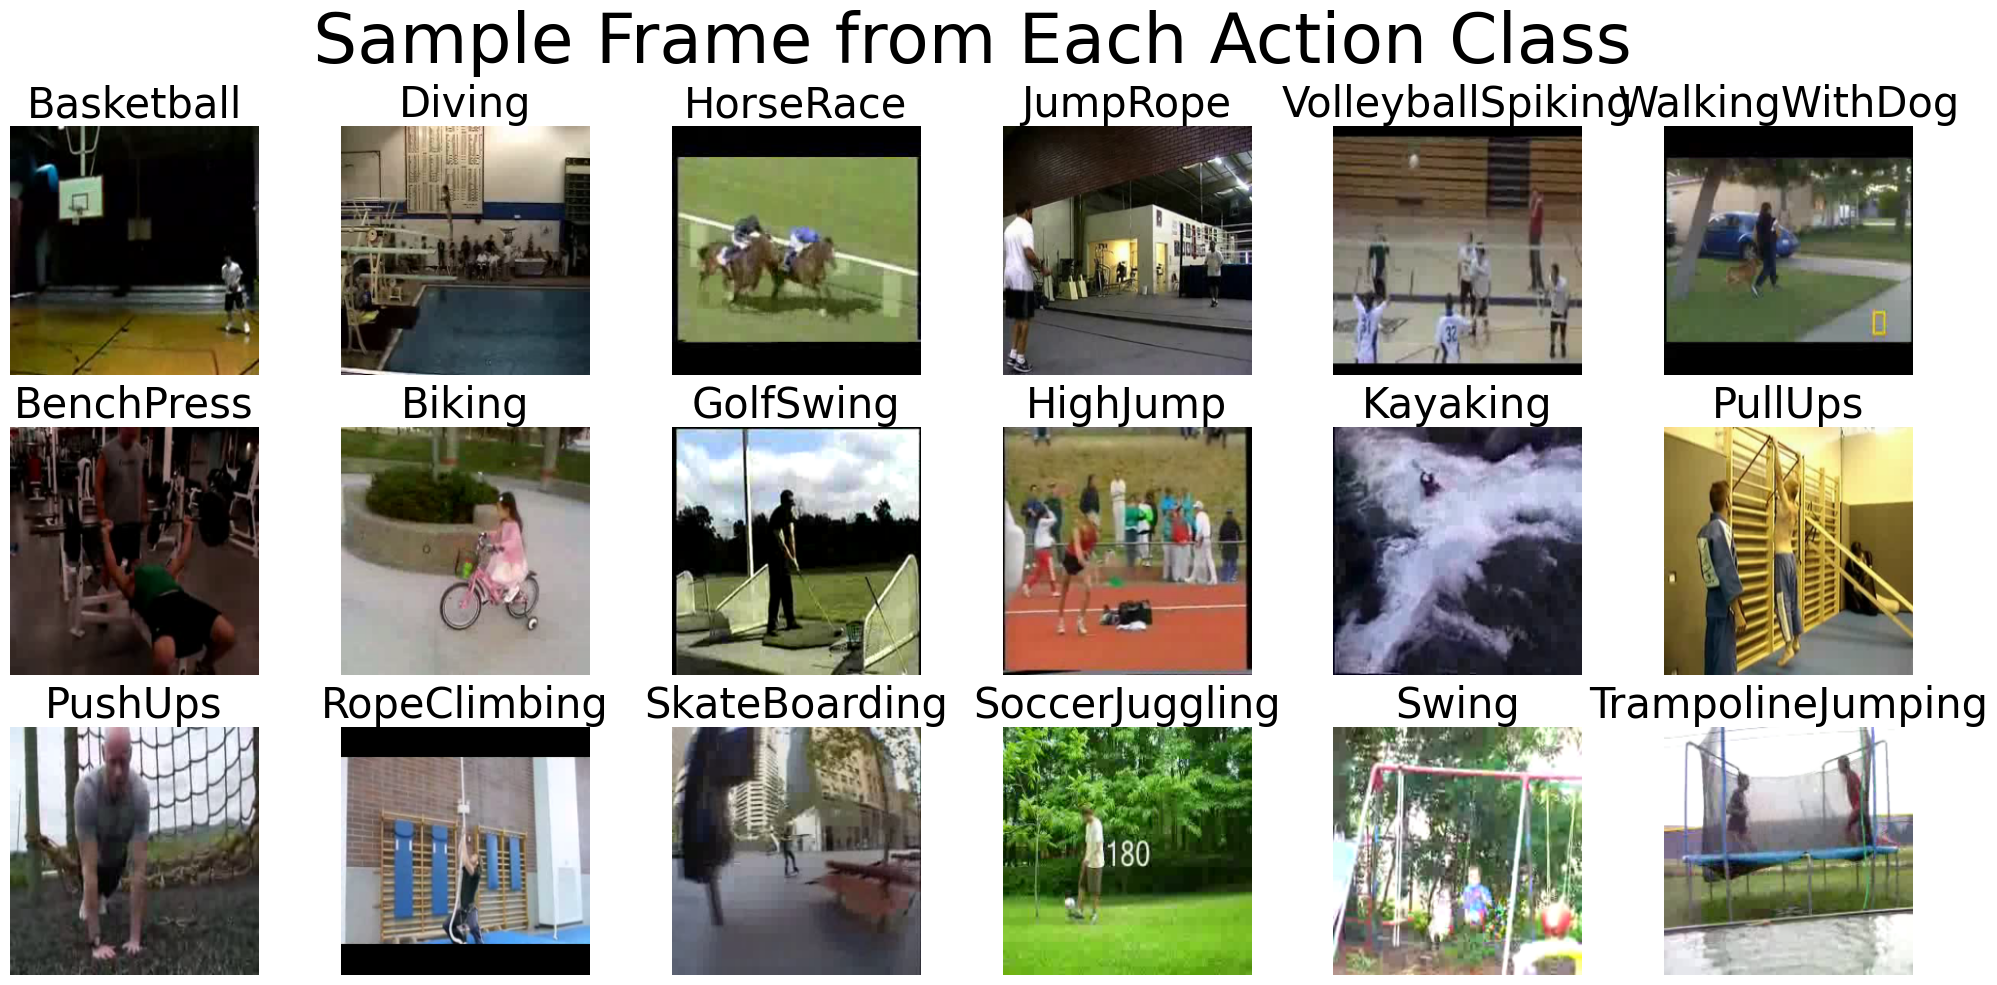

In [4]:
# Show 1 frame from 1 video of each class

def show_sample_frames(classes, dataset_path):
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # 3 rows and 6 columns
    axes = axes.flatten()  # make it easy to loop over

    for i, cls in enumerate(classes):
        # Load first video from the class folder
        video_path = os.path.join(dataset_path, cls, os.listdir(os.path.join(dataset_path, cls))[0])
        cap = cv2.VideoCapture(video_path) #think of cap like a video player that's paused and ready to play frame by frame.

        # ret: a boolean (True/False) — it’s True if a frame was read successfully
        # frame: the actual image/frame (as a NumPy array)
        ret, frame = cap.read()
        cap.release() # This closes the video file after you're done

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (256, 256))
            axes[i].imshow(frame)
            axes[i].set_title(cls , fontsize = 30)
        axes[i].axis('off')    

    plt.suptitle(" Sample Frame from Each Action Class", fontsize=50)
    plt.tight_layout()
    plt.show()

# Calling
show_sample_frames(selected_classes, dataset_path)


# Extract Frames from Videos

In [5]:
#  Extract fixed number of frames from each video
# For simplicity and speed, we’ll extract 20 frames per video

def extract_frames(video_path, num_frames=20):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // num_frames, 1)
    
    count = 0
    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame = cv2.resize(frame, (64, 64))
            frame = frame / 255.0  # Normalize pixel values
            frames.append(frame)
        count += 1
    cap.release()

    # Pad with last frame if video too short
    while len(frames) < num_frames:
        frames.append(frames[-1])
    
    return np.array(frames)


# Load Videos and Create Dataset

In [6]:
# Loop through videos in selected classes and extract frames
X = []
y = []

for class_index, cls in enumerate(selected_classes):
    class_path = os.path.join(dataset_path, cls)
    videos = os.listdir(class_path)  

    for video in videos:
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path, num_frames=20)
        if frames.shape == (20, 64, 64, 3):  # Ensure consistent shape
            X.append(frames)
            y.append(class_index)

X = np.array(X)
y = to_categorical(y) # One-Hot

print(" Data Loaded:")
print("X shape:", X.shape)  # (samples, time_steps, height, width, channels)
print("y shape:", y.shape)  # (samples, num_classes)


 Data Loaded:
X shape: (2419, 20, 64, 64, 3)
y shape: (2419, 18)


# Train-Test Split

In [7]:
#  Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training videos:", X_train.shape[0])
print("Testing videos:", X_test.shape[0])


Training videos: 1935
Testing videos: 484


In [9]:
X_train.shape

(1935, 20, 64, 64, 3)

In [10]:
X_test.shape

(484, 20, 64, 64, 3)

In [11]:
y_train.shape

(1935, 18)

In [12]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 3D-CNN model

In [8]:
input_x = Input(shape=(20, 64, 64, 3))  # 20 frames, 64x64 RGB

x = Conv3D(32, kernel_size=(3,3,3), padding='same')(input_x)
x = LeakyReLU(alpha=0.001)(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(64, kernel_size=(3,3,3), padding='same')(x)
x = LeakyReLU(alpha=0.001)(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Conv3D(128, kernel_size=(3,3,3), padding='same')(x)
x = LeakyReLU(alpha=0.001)(x)
x = MaxPooling3D(pool_size=(2,2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(18, activation='softmax')(x)  # 18 actions

model_3dcnn = Model(inputs=input_x, outputs=output)
model_3dcnn.compile(optimizer=Adam(learning_rate=0.0005),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_3dcnn.summary()

I0000 00:00:1763132721.082843      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 20, 64, 64, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d (Conv3D)                      │ (None, 20, 64, 64, 32)      │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 20, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 10, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 10, 32, 32, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 10, 32, 32, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 5, 16, 16, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 5, 16, 16, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 5, 16, 16, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 2, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 18)                  │           4,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,478,482 (17.08 MB)

 Trainable params: 4,478,482 (17.08 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#  Train the model
history = model_3dcnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=4)


Epoch 1/10


I0000 00:00:1763132812.012446    9851 service.cc:148] XLA service 0x7c57c0002d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763132812.012970    9851 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763132812.294741    9851 cuda_dnn.cc:529] Loaded cuDNN version 90300


  9/484 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.0786 - loss: 2.9808

I0000 00:00:1763132815.334171    9851 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


484/484 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.0750 - loss: 2.8960 - val_accuracy: 0.2293 - val_loss: 2.5505
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2375 - loss: 2.4843 - val_accuracy: 0.4649 - val_loss: 1.7498
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.4394 - loss: 1.7641 - val_accuracy: 0.6653 - val_loss: 1.1705
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.6430 - loss: 1.1764 - val_accuracy: 0.7252 - val_loss: 0.9252
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7782 - loss: 0.7526 - val_accuracy: 0.7500 - val_loss: 0.8835
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8503 - loss: 0.5090 - val_accuracy: 0.8099 - val_loss: 0.7375
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8944 - loss: 0.3317 - val_accuracy: 0.7975 - val_loss: 0.7374
Epoch 8/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9327 - loss: 0.2488 - val_accuracy: 0.77

In [15]:
test_acc_3dcnn=model_3dcnn.evaluate(X_test, y_test)
test_acc_3dcnn

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8068 - loss: 1.0354


[0.9742579460144043, 0.8057851195335388]

# LRCN model

In [17]:
model_lrcn = Sequential()

# CNN applied to each frame
model_lrcn.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(20, 64, 64, 3)))
model_lrcn.add(TimeDistributed(MaxPooling2D(2,2)))
model_lrcn.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model_lrcn.add(TimeDistributed(MaxPooling2D(2,2)))
model_lrcn.add(TimeDistributed(Flatten()))

# LSTM for temporal pattern learning
model_lrcn.add(LSTM(128))
model_lrcn.add(Dropout(0.5))

# Classification head
model_lrcn.add(Dense(18, activation='softmax'))

model_lrcn.compile(optimizer=Adam(learning_rate=0.0005),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

model_lrcn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 20, 62, 62, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 20, 31, 31, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 20, 29, 29, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 14, 14, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 12544)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       6,488,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,510,290 (24.83 MB)

 Trainable params: 6,510,290 (24.83 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#  Train the model
history = model_lrcn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=4)


Epoch 1/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.1427 - loss: 2.7958 - val_accuracy: 0.4215 - val_loss: 2.0603
Epoch 2/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.4780 - loss: 1.7845 - val_accuracy: 0.5930 - val_loss: 1.3742
Epoch 3/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6704 - loss: 1.1468 - val_accuracy: 0.7417 - val_loss: 0.9777
Epoch 4/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.7771 - loss: 0.7895 - val_accuracy: 0.7438 - val_loss: 0.8984
Epoch 5/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.8690 - loss: 0.4901 - val_accuracy: 0.7417 - val_loss: 0.8627
Epoch 6/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9191 - loss: 0.3173 - val_accuracy: 0.8079 - val_loss: 0.6646
Epoch 7/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9577 - loss: 0.1895 - val_accuracy: 0.7872 - val_loss: 0.7433
Epoch 8/10
484/484 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9709 - loss: 0.1327 - 

In [20]:
test_acc_lrcn=model_lrcn.evaluate(X_test, y_test)
test_acc_lrcn

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7904 - loss: 0.7030


[0.6962927579879761, 0.797520637512207]

# Show Model Predictions on 5 Random Test Videos


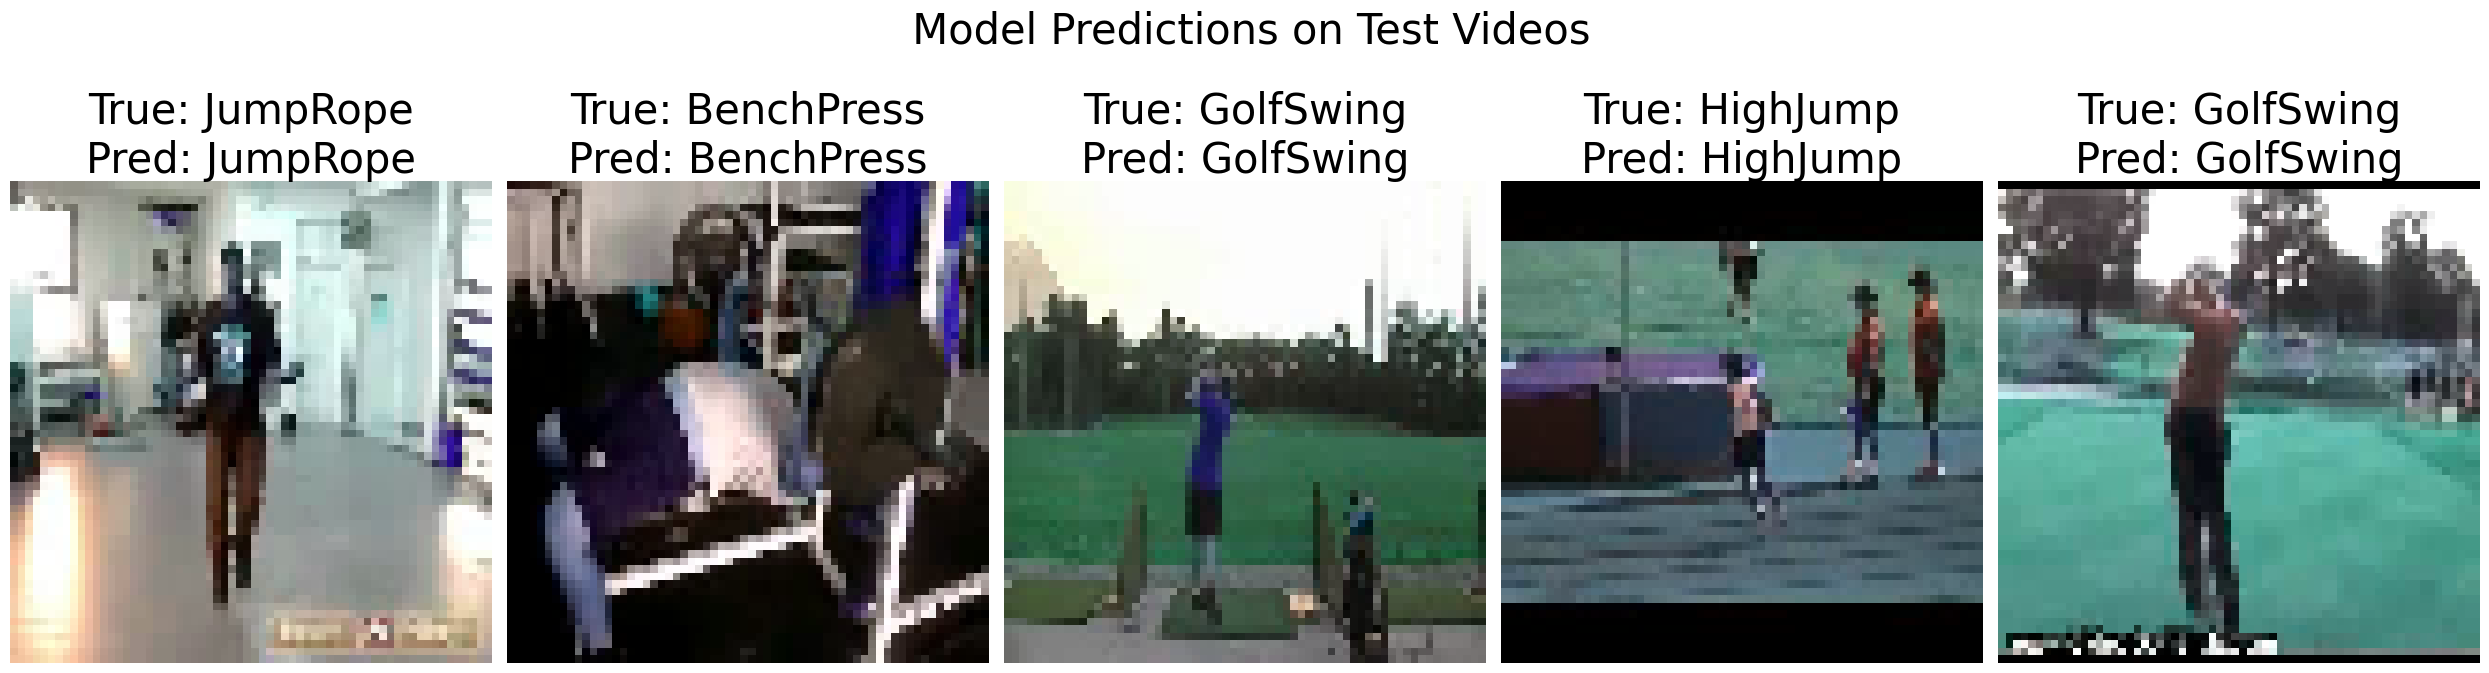

In [21]:
#  Visualize model predictions on 5 test videos (larger images)
def show_predictions(model, X_test, y_test, class_names):
    # Get 5 random indices
    indices = np.random.choice(len(X_test), 5, replace=False)
    
    # Bigger canvas size
    fig, axes = plt.subplots(1, 5, figsize=(25, 8))  #  Wider and taller

    for i, idx in enumerate(indices):
        video = X_test[idx]
        true_label = class_names[np.argmax(y_test[idx])]

        # Predict
        prediction = model.predict(np.expand_dims(video, axis=0), verbose=0)
        predicted_label = class_names[np.argmax(prediction)]

        # Get middle frame and denormalize
        mid_frame = video[len(video) // 2]
        mid_frame = (mid_frame * 255).astype(np.uint8)

        # Optional: remove resizing if frame is already big enough
        # frame = cv2.resize(mid_frame, (256, 256))  # or skip this
        frame = mid_frame  # Show full original frame size

        # Plot
        axes[i].imshow(frame)
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=30)
        axes[i].axis('off')

    plt.suptitle(" Model Predictions on Test Videos", fontsize=30)
    plt.tight_layout()
    plt.show()

#  Run it
show_predictions(model_3dcnn, X_test, y_test, selected_classes)


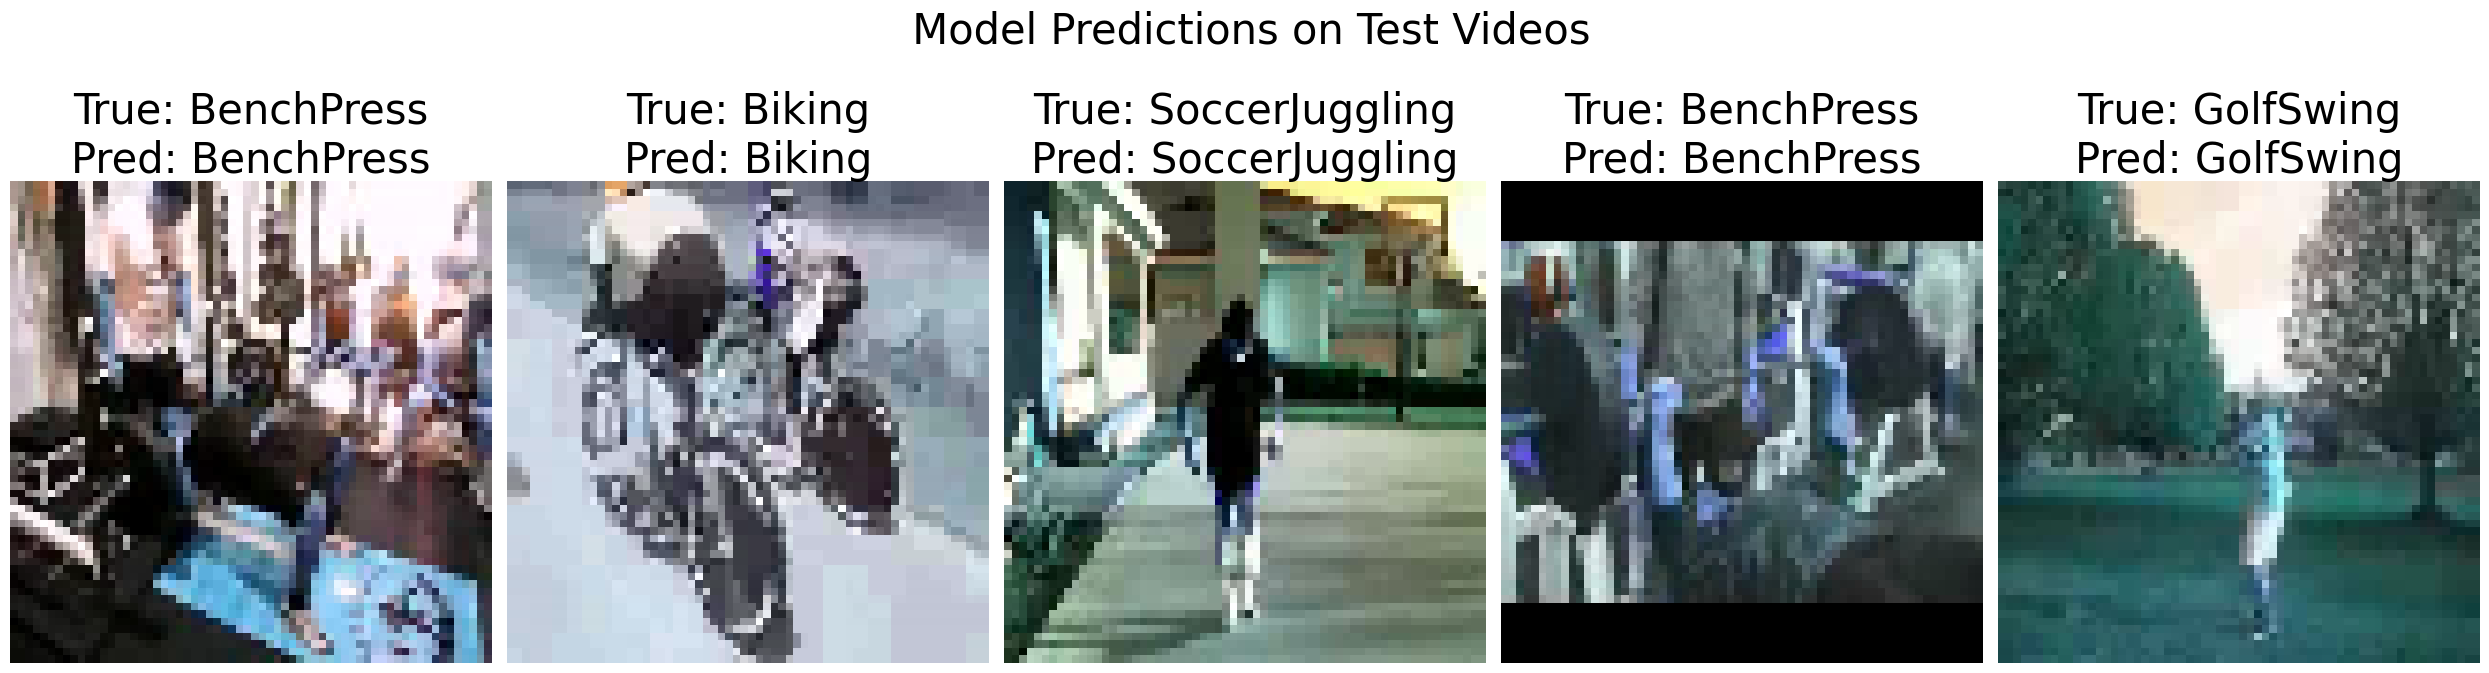

In [22]:
show_predictions(model_lrcn, X_test, y_test, selected_classes)


# Final Notes

In [23]:
#  Summary for Learners:
print("1- We built an action recognition model using 3D-CNN and LRCN model")
print("2- CNN: Extracted spatial features from each frame")
print("3- LSTM: Learned sequence of actions over time")
print("4- Only 18 classes used to keep it simple")

print("****"*4)
print("In the future I will improve it by:")
print("1- Using more video samples")
print("2- Using data augmentation or 3D CNNs")
print("3- Trying all 50 classes in UCF50")


1- We built an action recognition model using 3D-CNN and LRCN model
2- CNN: Extracted spatial features from each frame
3- LSTM: Learned sequence of actions over time
4- Only 18 classes used to keep it simple
****************
In the future I will improve it by:
1- Using more video samples
2- Using data augmentation or 3D CNNs
3- Trying all 50 classes in UCF50
